In [1]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    print(dirname)
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input
/kaggle/input/happy-whale-and-dolphin
/kaggle/input/happy-whale-and-dolphin/train_images
/kaggle/input/happy-whale-and-dolphin/test_images


In [2]:
import gc
import glob
import os

import joblib
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

from contextlib import contextmanager
from multiprocessing.pool import ThreadPool, Pool
from joblib import Parallel, delayed
import time

%matplotlib inline

# Exmplore the initial `train.csv` file

In [3]:
CPUS = 4 # kaggle default - https://www.kaggle.com/product-feedback/64106
happywhale_input_dir = "/kaggle/input/happy-whale-and-dolphin"
train_csv_fn = "train.csv"
# order by image jpg file and reset index to have deterministic index
train_df = pd.read_csv(os.path.join(happywhale_input_dir, train_csv_fn)).sort_values('image').reset_index()

train_df.species.replace({"globis": "short_finned_pilot_whale",
                          "pilot_whale": "short_finned_pilot_whale",
                          "kiler_whale": "killer_whale",
                          "bottlenose_dolpin": "bottlenose_dolphin"}, inplace=True)

In [4]:
for c in train_df.columns:
    print('number of {}: {}'.format(c, len(train_df[c].unique())))


number of index: 51033
number of image: 51033
number of species: 26
number of individual_id: 15587


There are 51033 images to process.

First, let's see what the images look like.
- are they all the same dimensions?
- are they all rgb or are there some potential grayscale images?

In [5]:
train_df

,index,image,species,individual_id
0,0,00021adfb725ed.jpg,melon_headed_whale,cadddb1636b9
1,1,000562241d384d.jpg,humpback_whale,1a71fbb72250
2,2,0007c33415ce37.jpg,false_killer_whale,60008f293a2b
3,3,0007d9bca26a99.jpg,bottlenose_dolphin,4b00fe572063
4,4,00087baf5cef7a.jpg,humpback_whale,8e5253662392
...,...,...,...,...
51028,51028,fff639a7a78b3f.jpg,beluga,5ac053677ed1
51029,51029,fff8b32daff17e.jpg,cuviers_beaked_whale,1184686361b3
51030,51030,fff94675cc1aef.jpg,blue_whale,5401612696b9
51031,51031,fffbc5dd642d8c.jpg,beluga,4000b3d7c24e


# Processing the Images

In [6]:
from skimage.io import imread
from skimage.transform import resize
from skimage.color import rgb2gray, gray2rgb
import matplotlib.pyplot as plt

def convert_image_to_ndarray(img_path, output_size=(256,256), color='normalize_gray'):
    '''
    reads the `img_path` and converts it to a numpy array of size `output_size`
    Supported Options for `color`:
    - 'normalize_gray'
    - 'raw_rgb'
    
    Returns the 
    1. normalized and standardized image
    2. aspect ratio of the original image
    '''
    # read input
    im = imread(img_path)
    if output_size == None:
        return im
    aspect_ratio = float(im.shape[1] / im.shape[0])
    resized_im = resize(im, output_size)
    if color == 'raw_rgb':
        return resized_im, aspect_ratio
    elif color == 'normalize_gray':
        # if image only has 2 channels, it's already grayscale
        if len(resized_im.shape) == 2:
            return resized_im / np.max(resized_im), aspect_ratio
        # if image has 3 channels. it's rgb and needs to be converted to grayscale
        elif len(resized_im.shape) == 3:
            gray_img = rgb2gray(resized_im)
            # Now normalize gray image
            gray_norm = gray_img / np.max(gray_img)
            return gray_norm, aspect_ratio
        
def convert_ndarray_img_to_maintain_aspect_ratio(ndarray_img, ar):
    '''
    aspect ratio is width / height
    '''
    new_width = ndarray_img.shape[1]*ar # new width should be aspect ratio * img width
    new_ar_shape = (ndarray_img.shape[0], new_width)
    return resize(ndarray_img, new_ar_shape)


# create lambda function to construct the full path for a given image.
# this is intended to be used on the `image` column in train.csv
get_img_path = lambda img: os.path.join(happywhale_input_dir, img)

## Processing a sample image

In [7]:
sample_img = train_df.sample(1).iloc[0]
sample_image = sample_img.image
sample_species = sample_img.species
sample_id = sample_img.individual_id

In [8]:
sample_path = get_img_path('train_images/' + sample_image)
sample_ndarray, sample_ar = convert_image_to_ndarray(sample_path)

(256, 256)
bb3fe773f7fb sei_whale


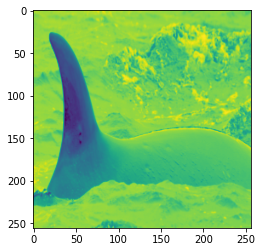

In [9]:
print(sample_ndarray.shape)
print(sample_id,  sample_species)
plt.imshow(sample_ndarray)

## Processing an odd image (gray scale)

The image `00398cfc6f6675.jpg` is odd because it is already in gray scale (there are no rgb colors). Additionally, it has an extended shape, such that the orginal is very wide, but short.

As a result of processing the image to a 256x256 pixel (default) image, the aspect ratio is lost. This may ratio may provide critical info when classifying the sharpenss and shape of dorsal fins.

In [10]:
train_df[train_df['image']=='00398cfc6f6675.jpg']

,index,image,species,individual_id
38,38,00398cfc6f6675.jpg,beluga,90c9eaca0927


In [11]:
err_path = get_img_path('train_images/00398cfc6f6675.jpg')
err_ndarray, ar = convert_image_to_ndarray(err_path)


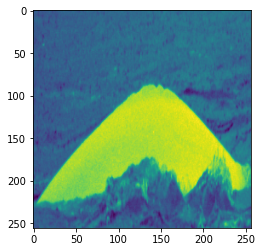

In [12]:
plt.imshow(err_ndarray)

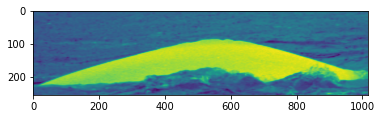

In [13]:

plt.imshow(convert_ndarray_img_to_maintain_aspect_ratio(err_ndarray, ar))

In [14]:
# https://medium.com/codebyte/add-progress-bar-to-your-for-loops-5f0a50500ff3
from tqdm import tqdm

def pixelize_images_in_df(df, show_progress_bar=False):
    '''
    Processes the dataframe from `train.csv` or `sample_submission.csv`
    1. converting each image to a normalized grayscale (256x256) pixel representation
    2. creating 256*256 + 1 additional features to the original dataframe
        - each feature is 1 pixel from step 1.
        - final feature is the aspect ratio of the original image
    '''
    images = df.image
    flat_ndarray_images = []
    aspect_ratios = []
    n_pixels = 256
    output_shape = (n_pixels,n_pixels)
    items = tqdm(images) if show_progress_bar else images
    for img in items:
        img_path = get_img_path('train_images/' + img)
        ndarray, ar = convert_image_to_ndarray(img_path, output_size=output_shape)
        
        flat_ndarray_images.append(ndarray.reshape(n_pixels*n_pixels))
        aspect_ratios.append(ar)
        
    # construct final dataframe to return
    pixelized_images_df = pd.DataFrame(flat_ndarray_images, index=df.index)
    pixelized_images_df['aspect_ratio'] = aspect_ratios
    return pd.merge(df, pixelized_images_df, left_index=True, right_index=True)

## Parallel Data Processsing the `train.csv`

First, let's run an experiment on a sample of 20 to see which parallization method is fastest for processing the images.

### References
- https://www.kaggle.com/wrosinski/parallel-data-processing-and-model-training

In [15]:
# https://www.kaggle.com/wrosinski/parallel-data-processing-and-model-training

@contextmanager
def timer(name):
    t0 = time.time()
    yield
    print('{0} done in {1:.3f} seconds.'.format(name, time.time() - t0))

def split_df(df, num_splits, log=False):
    
    df_list = []
    rows_splits = np.linspace(0, df.shape[0], num_splits+1).astype(int)
    if log:
        print('Split into {} parts'.format(num_splits))
        print('Row splits:\n{}'.format(rows_splits))
    
    for i in range(len(rows_splits) - 1):
        df_list.append(df.iloc[rows_splits[i]:rows_splits[i+1]])
        
    return df_list[:num_splits]

In [16]:
n_samples = 4*10 # None # changing this to None will use the entire train_df
experimental_df = train_df[:n_samples]
experimental_dfs_split = split_df(experimental_df, CPUS)
experimental_dfs_ = pd.concat(experimental_dfs_split, ignore_index=True, sort=False)

In [17]:
experimental_dfs_split

[   index               image             species individual_id
 0      0  00021adfb725ed.jpg  melon_headed_whale  cadddb1636b9
 1      1  000562241d384d.jpg      humpback_whale  1a71fbb72250
 2      2  0007c33415ce37.jpg  false_killer_whale  60008f293a2b
 3      3  0007d9bca26a99.jpg  bottlenose_dolphin  4b00fe572063
 4      4  00087baf5cef7a.jpg      humpback_whale  8e5253662392
 5      5  000a8f2d5c316a.jpg  bottlenose_dolphin  b9907151f66e
 6      6  000be9acf46619.jpg              beluga  afb9b3978217
 7      7  000bef247c7a42.jpg      humpback_whale  444d8894ccc8
 8      8  000c3d63069748.jpg              beluga  df94b15285b9
 9      9  000c476c11bad5.jpg  bottlenose_dolphin  b11b2404c7e3,
     index               image             species individual_id
 10     10  001001f099519f.jpg         minke_whale  19fbb960f07d
 11     11  00103cbe9d25ce.jpg           fin_whale  180c0ab04dcd
 12     12  00144776eb476d.jpg  bottlenose_dolphin  b9907151f66e
 13     13  00167e8375c967.jpg     

#### Baseline time to process 40 images

In [18]:
#processed_df = process_train_df(train_df[:6])

with timer('datetime processing:'):
    experimental_df_ = pixelize_images_in_df(experimental_df, show_progress_bar=True)

100%|██████████| 40/40 [00:46<00:00,  1.17s/it]


datetime processing: done in 49.317 seconds.


In [19]:
experimental_df_

,index,image,species,individual_id,0,1,2,3,4,5,...,65527,65528,65529,65530,65531,65532,65533,65534,65535,aspect_ratio
0,0,00021adfb725ed.jpg,melon_headed_whale,cadddb1636b9,0.463753,0.469581,0.477523,0.487009,0.498406,0.511733,...,0.201963,0.192882,0.200069,0.197648,0.195564,0.196354,0.200686,0.199245,0.197579,1.198212
1,1,000562241d384d.jpg,humpback_whale,1a71fbb72250,0.833581,0.840353,0.845824,0.827661,0.828294,0.857705,...,0.861722,0.864713,0.859254,0.846934,0.832020,0.829230,0.843044,0.853534,0.855525,1.500000
2,2,0007c33415ce37.jpg,false_killer_whale,60008f293a2b,0.663449,0.670953,0.681730,0.680676,0.693642,0.702199,...,0.691140,0.688582,0.676637,0.689521,0.676711,0.666995,0.666486,0.666531,0.653706,1.500208
3,3,0007d9bca26a99.jpg,bottlenose_dolphin,4b00fe572063,0.543918,0.598159,0.644220,0.672533,0.703838,0.735460,...,0.300331,0.309465,0.315749,0.314464,0.310216,0.313937,0.327092,0.326221,0.318659,1.500000
4,4,00087baf5cef7a.jpg,humpback_whale,8e5253662392,0.396056,0.374476,0.387099,0.370121,0.380355,0.390234,...,0.350706,0.355065,0.357953,0.361097,0.361008,0.360607,0.358741,0.355178,0.351214,1.333457
5,5,000a8f2d5c316a.jpg,bottlenose_dolphin,b9907151f66e,0.727182,0.743250,0.749441,0.751597,0.739088,0.726531,...,0.658858,0.675568,0.694625,0.713584,0.707712,0.708075,0.715902,0.722552,0.719074,1.500000
6,6,000be9acf46619.jpg,beluga,afb9b3978217,0.459196,0.426789,0.444362,0.453244,0.464838,0.443469,...,0.574179,0.573082,0.559099,0.597367,0.611254,0.622483,0.625033,0.632379,0.619221,3.932584
7,7,000bef247c7a42.jpg,humpback_whale,444d8894ccc8,0.739286,0.740062,0.740072,0.741292,0.741357,0.743443,...,0.387340,0.405948,0.434217,0.430417,0.407707,0.407206,0.316474,0.303871,0.370241,1.500000
8,8,000c3d63069748.jpg,beluga,df94b15285b9,0.502972,0.493980,0.490700,0.492119,0.492681,0.485694,...,0.479749,0.466936,0.469607,0.466498,0.464025,0.455233,0.461328,0.472920,0.468736,2.850000
9,9,000c476c11bad5.jpg,bottlenose_dolphin,b11b2404c7e3,0.211711,0.222648,0.228982,0.238866,0.272159,0.253871,...,0.408418,0.443029,0.453873,0.430588,0.417603,0.432074,0.441054,0.482185,0.539631,1.500000


####  Using different methods of parallization

In [20]:
with timer('pool pixelize images processing:'):
    with Pool(processes=CPUS) as pool:
        dfs_proc = pool.map(pixelize_images_in_df, experimental_dfs_split)
        

with timer('pool pixelize images processing threads:'):
    with ThreadPool(processes=CPUS) as pool:
        dfs_proc = pool.map(pixelize_images_in_df, experimental_dfs_split)

pool pixelize images processing: done in 23.438 seconds.
pool pixelize images processing threads: done in 24.641 seconds.


In [21]:
with timer('joblib parallel pixelize images processing:'):
    dfs_proc = Parallel(n_jobs=CPUS)(delayed(pixelize_images_in_df)(i) for i in experimental_dfs_split)
    
    
with timer('joblib parallel pixelize images processing threads:'):
    dfs_proc = Parallel(n_jobs=CPUS, prefer='threads')(delayed(pixelize_images_in_df)(i) for i in experimental_dfs_split)


joblib parallel pixelize images processing: done in 26.233 seconds.
joblib parallel pixelize images processing threads: done in 24.744 seconds.


In [22]:
with timer('pool pixelize images processing:'):
    with Pool(processes=CPUS) as pool:
        dfs_proc = pool.map(pixelize_images_in_df, experimental_dfs_split)

with timer('joblib parallel pixelize images processing:'):
    dfs_proc = Parallel(n_jobs=CPUS)(delayed(pixelize_images_in_df)(i) for i in experimental_dfs_split)
    

pool pixelize images processing: done in 23.373 seconds.
joblib parallel pixelize images processing: done in 23.373 seconds.


In [23]:
time_taken_per_image = 17.654 / 40 # 17.654 seconds from 4 Pools
n_images_to_process = 51033
estimated_time_in_seconds = time_taken_per_image*n_images_to_process
estimated_time_in_minutes = time_taken_per_image*n_images_to_process / 60
estimated_time_in_hours = time_taken_per_image*n_images_to_process / 3600
print("Estimated time to process {}: {} seconds".format(n_images_to_process, estimated_time_in_seconds))
print("Estimated time to process {}: {} minutes".format(n_images_to_process, estimated_time_in_minutes))
print("Estimated time to process {}: {} hours".format(n_images_to_process, estimated_time_in_hours))

Estimated time to process 51033: 22523.41455 seconds
Estimated time to process 51033: 375.3902425 minutes
Estimated time to process 51033: 6.256504041666667 hours


### Summary of timing experiment

40 images pixelized and processed.
Time for: 
- Baseline (Sequential): 47.173s
- Pool: 17.654s
- Threadpool: 21.775s
- joblib Parallel jobs: 19.558s
- joblib parallel jobs with threads: 21.839s

Seems like using regular pools is the fastest. This makes sense because threading will create more overhead than distributing the task to workers, especially since we only have 4 CPUs.

### Conclusions of experiment

We'll process the entire dataset by parallelizing the data processing in batches such that if while running the processing the notebook dies, we'll be able to continue where we left off.

## Processing Images in batches

In [24]:
def pool_process_and_dump(df, output_path_from_batch_processed, timer_str, CPUS=4, log=False):
    df_splits = split_df(df, CPUS, log=log)
    with timer(timer_str):
        with Pool(processes=CPUS) as pool:
            dfs_proc = pool.map(pixelize_images_in_df, df_splits)
    processed_df = pd.concat(dfs_proc)
    
    output_dir = '/kaggle/working'
    batch_process_dir = os.path.join(output_dir, 'batch_processed')
    if not os.path.exists(batch_process_dir):
        os.makedirs(batch_process_dir)
    batch_process_fn = os.path.join(batch_process_dir,
                            output_path_from_batch_processed)
    processed_df.to_csv(batch_process_fn, index=False)

In [25]:
# min(train_df.species.value_counts())
# Simple training set will be composed of 14 of each species with pairs of each individual id
all_species_training_sets = []
n_each_species = min(train_df.species.value_counts())
print('Using {} of each species'.format(n_each_species))
for s in train_df.species.unique():
    sample = train_df[train_df.species == s].head(n_each_species) # use head to be deterministic for sample
    all_species_training_sets.append(sample)
    
all_species_train_df = pd.concat(all_species_training_sets)
pool_process_and_dump(all_species_train_df,
                      'processed_batch_df_all_species.csv',
                      'pool pixelize images processing all species df')

# sample up to 1000 for training set
remaining_training_set = 1000 - len(all_species_train_df)
batch_size = 40

left_off_on_n = 0
continue_until_n = remaining_training_set # None # changing this to None will use the entire train_df
while left_off_on_n < continue_until_n:
    next_batch_index = left_off_on_n+batch_size
    
    sampled_df = train_df.sample(batch_size, random_state=left_off_on_n)
    pool_process_and_dump(sampled_df,
                      'processed_batch_sampled_df_random_state_{}.csv'.format(left_off_on_n),
                      'pool pixelize images processing sampled batch')
    
    left_off_on_n = next_batch_index


Using 14 of each species
pool pixelize images processing all species df done in 158.201 seconds.
pool pixelize images processing sampled batch done in 27.024 seconds.
pool pixelize images processing sampled batch done in 26.280 seconds.
pool pixelize images processing sampled batch done in 25.903 seconds.
pool pixelize images processing sampled batch done in 28.807 seconds.
pool pixelize images processing sampled batch done in 19.781 seconds.
pool pixelize images processing sampled batch done in 27.606 seconds.
pool pixelize images processing sampled batch done in 24.498 seconds.
pool pixelize images processing sampled batch done in 19.577 seconds.
pool pixelize images processing sampled batch done in 22.293 seconds.
pool pixelize images processing sampled batch done in 17.102 seconds.
pool pixelize images processing sampled batch done in 26.308 seconds.
pool pixelize images processing sampled batch done in 17.859 seconds.
pool pixelize images processing sampled batch done in 20.366 se

## Simple model

In [26]:
# # min(train_df.species.value_counts())
# # Simple training set will be composed of 14 of each species
# simple_training_sets = []
# n_each_species = min(train_df.species.value_counts())
# for s in train_df.species.unique():
#     sample = train_df[train_df.species == s].sample(n_each_species)
#     simple_training_sets.append(sample)
    
# simple_training_df = pd.concat(simple_training_sets)
# simple_training_df

In [27]:
# val_df = train_df.sample(50)

In [28]:
# simple_train_dfs_split = split_df(simple_training_df, CPUS)
# simple_training_df_ = pd.concat(simple_train_dfs_split, ignore_index=True, sort=False)

# with timer('pool pixelize images processing:'):
#     with Pool(processes=4) as pool:
#         simple_training_df_processed = pool.map(pixelize_images_in_df, simple_train_dfs_split)

In [29]:
# val_dfs_split = split_df(val_df, CPUS)
# val_df_ = pd.concat(val_dfs_split, ignore_index=True, sort=False)

# with timer('pool pixelize images processing:'):
#     with Pool(processes=4) as pool:
#         val_df_processed = pool.map(pixelize_images_in_df, val_dfs_split)

In [30]:
# simple_training_df_processed_combined = pd.concat(simple_training_df_processed)
# val_df_processed_combined = pd.concat(val_df_processed)

In [31]:
# X_train = simple_training_df_processed_combined.drop(['image', 'species', 'individual_id'], axis=1)
# Y_train = simple_training_df_processed_combined['species']
# X_val = val_df_processed_combined.drop(['image', 'species', 'individual_id'], axis=1)
# Y_val = val_df_processed_combined['species']

In [32]:
# from sklearn.neighbors import KNeighborsClassifier
# knn = KNeighborsClassifier(n_neighbors=1)
# knn.fit(X, Y)
# knn_score = knn.score(X, Y)
# print(knn_score)

In [33]:
# # knn.predict(pixelize_images_in_df(train_df.sample(1)))
# # pixelize_images_in_df(train_df.sample(1)).drop(['image', 'species', 'individual_id'], axis=1)

# sample_test = pixelize_images_in_df(train_df.sample(1))
# sample_test

In [34]:
# knn.predict(sample_test.drop(['image', 'species', 'individual_id'], axis=1))

In [35]:
# plt.imshow(plt.imread(get_img_path('train_images/0a1087a33b933d.jpg')))

## Face ID - Siamese Model
From https://towardsdatascience.com/how-i-implemented-iphone-xs-faceid-using-deep-learning-in-python-d5dbaa128e1d

In [36]:
# from itertools import combinations

# def create_pairs(df, on='image'):
#     paired = pd.DataFrame(list(combinations(df['image'],2)), columns=['dump', 'siamese_image'])
#     return pd.merge(df, paired, how='outer', left_on=on, right_on='dump').drop('dump', axis=1).dropna()
    
# def pixelize_siamese_images_in_df(df, show_progress_bar=False):
#     '''
#     Processes the dataframe from `train.csv` or `sample_submission.csv`
#     1. converting each image to a normalized grayscale (256x256) pixel representation
#     2. creating 256*256 + 1 additional features to the original dataframe
#         - each feature is 1 pixel from step 1.
#         - final feature is the aspect ratio of the original image
#     '''
#     images = df.image
#     siamese_images = df.siamese_image
#     flat_ndarray_images = []
#     aspect_ratios = []
#     siamese_aspect_ratios = []
#     n_pixels = 256
#     output_shape = (n_pixels,n_pixels)
#     items = tqdm(images) if show_progress_bar else images
#     siamese_items = tqdm(images) if show_progress_bar else siamese_images
#     for img, siamese_img in zip(items, siamese_items):
#         img_path = get_img_path('train_images/' + img)
#         siamese_img_path = get_img_path('train_images/' + siamese_img)
        
#         ndarray, ar = convert_image_to_ndarray(img_path, output_size=output_shape)
#         siamese_ndarray, siamese_ar = convert_image_to_ndarray(siamese_img_path, output_size=output_shape)
# #         print(ndarray.shape, siamese_ndarray.shape)
# #         stacked_array = (ndarray.reshape(n_pixels*n_pixels), siamese_ndarray.reshape(n_pixels*n_pixels))
#         stacked_ndarray = np.stack((ndarray, siamese_ndarray), axis=2)
        
#         flat_ndarray_images.append(stacked_ndarray)
#         aspect_ratios.append(ar)
#         siamese_aspect_ratios.append(siamese_ar)
        
#     # construct final dataframe to return
# #     cols = pd.MultiIndex.from_product([range(n_pixels*n_pixels), ['image', 'siamese_image']])
# #     pixelized_images_df = pd.DataFrame(flat_ndarray_images, columns=cols, index=df.index)
# #     pixelized_images_df['aspect_ratio'] = aspect_ratios
# #     pixelized_images_df['siamese_aspect_ratio'] = siamese_aspect_ratio
# #     return pd.merge(df, pixelized_images_df, left_index=True, right_index=True)
#     to_return = df.to_dict('list')
#     to_return.update({'images':flat_ndarray_images,
#             'image_aspect_ratios': aspect_ratios,
#             'siamese_aspect_ratios': siamese_aspect_ratios})
#     return to_return

# from functools import reduce
# def combine_pool_results(a, b):
#     return {k: a[k] + b[k] for k in a.keys()}

In [37]:
# # simple_training_df.individual_id.value_counts()
# uid_425f5ba95aef = all_species_train_df[all_species_train_df.individual_id == '425f5ba95aef']
# display(uid_425f5ba95aef)
# create_pairs(uid_425f5ba95aef)
# # pd.DataFrame({'uid':simple_training_df['individual_id'].unique()})

In [38]:


# # min(train_df.species.value_counts())
# # Simple training set will be composed of 14 of each species with pairs of each individual id
# faceid_training_sets = []
# n_each_species = min(train_df.species.value_counts())
# print('Using {} of each species'.format(n_each_species))
# for s in train_df.species.unique():
#     sample = train_df[train_df.species == s].head(n_each_species) # use head to be deterministic for sample
#     faceid_training_sets.append(sample)
    
# faceid_training_df = pd.concat(faceid_training_sets)
# faceid_training_df = pd.concat([create_pairs(faceid_training_df[faceid_training_df.individual_id==uid]) for uid in faceid_training_df.individual_id])

In [39]:
# faceid_training_df

In [40]:
# display(faceid_training_df[:4])
# faceid_training_dfs_split = split_df(faceid_training_df, CPUS)
# faceid_training_df_ = pd.concat(faceid_training_dfs_split, ignore_index=True, sort=False)

# with timer('pool pixelize images processing:'):
#     with Pool(processes=4) as pool:
#         faceid_training_mapped = pool.map(pixelize_siamese_images_in_df, faceid_training_dfs_split)
#     faceid_training_data = reduce(combine_pool_results, faceid_training_mapped)

In [41]:
# faceid_training_df = pd.DataFrame(faceid_training_data)
# faceid_training_df.head()#.keys()#['images'][0].shape

In [42]:
# faceid_X1 = np.array([img[:,:,0].reshape((256,256,1)) for img in faceid_training_df.images.values])
# faceid_X2 = np.array([img[:,:,1].reshape((256,256,1)) for img in faceid_training_df.images.values])
# faceid_Y = np.array([1.0 for uid in faceid_training_df.individual_id.values])# np.array([uid for uid in ])


In [43]:
# # plt.imshow(faceid_training_df.images.values[0][:,:,0].reshape((256,256,1)))
# faceid_X.shape

In [44]:
# sample_img = faceid_training_df.sample(1)
# sample_img

In [45]:

# plt.imshow(convert_ndarray_img_to_maintain_aspect_ratio(plt.imread(get_img_path('train_images/0039599b58fc80.jpg')), 1.500208))

In [46]:

# plt.imshow(convert_ndarray_img_to_maintain_aspect_ratio(sample_img.images.iloc[0][:,:,0], 1.500208))

In [47]:

# plt.imshow(convert_ndarray_img_to_maintain_aspect_ratio(plt.imread(get_img_path('train_images/0049b56a584eb1.jpg')), 1.500208))

In [48]:

# plt.imshow(convert_ndarray_img_to_maintain_aspect_ratio(sample_img.images.iloc[0][:,:,1], 1.500208))

In [49]:
# import random
# def faceid_generator(batch_size):
#     while 1:
#         X = []
#         y = []
#         for _ in range(batch_size):
#             sample = faceid_training_df.sample()
#             xx1 = sample.images.iloc[0][:,:,0]
#             xx2 = sample.images.iloc[0][:,:,1]
#             X.append([xx1, xx2])
#             y = sample.individual_id.iloc[0]
#         yield X, y

In [50]:
# faceid_training_df

In [51]:
# from keras.models import Sequential, Model
# from keras.layers import Dense, Activation, Flatten, Dropout, Lambda, ELU, concatenate, GlobalAveragePooling2D, Input, BatchNormalization, SeparableConv2D, Subtract, concatenate
# from keras.activations import relu, softmax
# from keras.layers.convolutional import Convolution2D
# from keras.layers.pooling import MaxPooling2D, AveragePooling2D
# from tensorflow.keras.optimizers import Adam, RMSprop, SGD
# from keras.regularizers import l2
# from keras import backend as K
# import tensorflow as tf

In [52]:
# def euclidean_distance(inputs):
#     assert len(inputs) == 2, \
#         'Euclidean distance needs 2 inputs, %d given' % len(inputs)
#     u, v = inputs
#     return K.sqrt(K.sum((K.square(u - v)), axis=1, keepdims=True))
        

# def contrastive_loss(y_true,y_pred):
#     margin=1.
#     return K.mean((1. - y_true) * K.square(y_pred) + y_true * K.square(K.maximum(margin - y_pred, 0.)))
#    # return K.mean( K.square(y_pred) )


In [53]:
# def fire(x, squeeze=16, expand=64):
#     x = Convolution2D(squeeze, (1,1), padding='valid')(x)
#     x = Activation('relu')(x)
    
#     left = Convolution2D(expand, (1,1), padding='valid')(x)
#     left = Activation('relu')(left)
    
#     right = Convolution2D(expand, (3,3), padding='same')(x)
#     right = Activation('relu')(right)
    
#     x = concatenate([left, right], axis=3)
#     return x

In [54]:

# tf.keras.backend.clear_session()

In [55]:
# tf.config.run_functions_eagerly(True)

---------------------

In [56]:
# img_input=Input(shape=(256,256, 1))

# x = Convolution2D(64, (5, 5), strides=(2, 2), padding='valid')(img_input)
# x = BatchNormalization()(x)
# x = Activation('relu')(x)
# x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)

# x = fire(x, squeeze=16, expand=16)

# x = fire(x, squeeze=16, expand=16)

# x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)


# x = fire(x, squeeze=32, expand=32)

# x = fire(x, squeeze=32, expand=32)

# x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)


# x = fire(x, squeeze=48, expand=48)

# x = fire(x, squeeze=48, expand=48)

# x = fire(x, squeeze=64, expand=64)

# x = fire(x, squeeze=64, expand=64)

# x = Dropout(0.2)(x)

# x = Convolution2D(512, (1, 1), padding='same')(x)
# out = Activation('relu')(x)


# modelsqueeze= Model(img_input, out)

# modelsqueeze.summary()

In [57]:
# im_in = Input(shape=(256,256,1))
# #wrong = Input(shape=(200,200,3))

# x1 = modelsqueeze(im_in)
# #x = Convolution2D(64, (5, 5), padding='valid', strides =(2,2))(x)

# #x1 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x1)

# """
# x1 = Convolution2D(256, (3,3), padding='valid', activation="relu")(x1)
# x1 = Dropout(0.4)(x1)

# x1 = MaxPooling2D(pool_size=(3, 3), strides=(1, 1))(x1)

# x1 = Convolution2D(256, (3,3), padding='valid', activation="relu")(x1)
# x1 = BatchNormalization()(x1)
# x1 = Dropout(0.4)(x1)

# x1 = Convolution2D(64, (1,1), padding='same', activation="relu")(x1)
# x1 = BatchNormalization()(x1)
# x1 = Dropout(0.4)(x1)
# """



# x1 = Flatten()(x1)

# x1 = Dense(512, activation="relu")(x1)
# x1 = Dropout(0.2)(x1)
# #x1 = BatchNormalization()(x1)
# feat_x = Dense(128, activation="linear")(x1)
# feat_x = Lambda(lambda  x: K.l2_normalize(x,axis=1))(feat_x)


# model_top = Model(inputs = [im_in], outputs = feat_x)

# model_top.summary()

# im_in1 = Input(shape=(256,256,1))
# im_in2 = Input(shape=(256,256,1))

# feat_x1 = model_top(im_in1)
# feat_x2 = model_top(im_in2)


# lambda_merge = Lambda(euclidean_distance)([feat_x1, feat_x2])


# model_final = Model(inputs = [im_in1, im_in2], outputs = lambda_merge)

# model_final.summary()

# adam = Adam(lr=0.001)

# sgd = SGD(lr=0.001, momentum=0.9)

# model_final.compile(optimizer=adam, loss=contrastive_loss)

In [58]:
# faceid_X.shape
# # faceid_Y.shape

In [59]:
# # def generator(batch_size):
# #     while 1:
# #         X=[]
# #         Y=[]
# #         for _ in range(batch_size):
# #             X.append()

# outputs = model_final.fit([faceid_X1, faceid_X2], faceid_Y, steps_per_epoch=30, epochs=50)


In [60]:
# References

# References
- https://towardsdatascience.com/how-i-implemented-iphone-xs-faceid-using-deep-learning-in-python-d5dbaa128e1d